# Prediction of Danish COVID-19 Cases with Gaussian Processes

Microsoft Cloud Solution Architect Soren Johansen

This notebook use the machine learning technique Gaussian Processes to predict the number of Danish COVID-19 patients that is hospitalized. This is also an example of how you apply Bayesian Statistics to a machine learning problem. Gaussian Processes is not mainstream Machine Learning, but are excellent to solve regression and probabilistic classification problems. Take a look at the examples here: 

* [Predict CO2 levels at Mauna LOA](https://docs.pymc.io/notebooks/GP-MaunaLoa.html)
* [Simple Example of Gaussian Smoothing](https://docs.pymc.io/notebooks/GP-smoothing.html)
* [Predictions using noisy observations](https://docs.pymc.io/notebooks/GP-Marginal.html)

I have used data from the Danish newspaper Politiken. The spreadsheet is also in this github folder. I have used the Bayesian Statistics Python package pymc3. In another blog I will give an overview of other packages for doing Bayesian Statistics in both R and Python. The sections in this notebook is:

* Import Danish COVID-19 figures
* Model Specification
* Fit Model
* Chain Diagnostics
* Predictions on hold-out-data
* Next step

On the documentation page for pymc3 there is a very light and quick introduction to [Gaussian Processes](
https://docs.pymc.io/Gaussian_Processes.html). It should also be noted that pymc3 also have an example of the classical epidemiology model [SIR](https://docs.pymc.io/notebooks/ODE_API_introduction.html), in a Bayesian setting. 


## Import Danish Corona figures

In [335]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import pymc3 as pm
from theano import shared
from scipy import optimize
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
%pylab inline
SEED = [20100420, 20134234]

Populating the interactive namespace from numpy and matplotlib


/Users/sorenjohansen/opt/anaconda3/envs/mcmc/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cov', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


The data is from the danish newspaper Politiken and you can see the figures [here](
https://public.flourish.studio/visualisation/1631132/?utm_source=showcase&utm_campaign=visualisation/1631132). The data was manually entered in a spreadsheet on the 05-04-2020.

In [867]:
df=pd.read_excel('Corona_tal_dk_05april.xlsx',parse_dates=True, index_col=0)

The data contains three columns "Hospitalized", "of which is in intensive care" and "of which is in respiratory care". 

In [868]:
df.dtypes

Indlagte i alt        int64
Heraf på Intensiv     int64
Heraf i respirator    int64
dtype: object

In [869]:
df.head()

,Indlagte i alt,Heraf på Intensiv,Heraf i respirator
Dato,,,
2020-03-15,28,2,0
2020-03-16,62,10,2
2020-03-17,82,18,4
2020-03-18,129,24,18
2020-03-19,153,30,27


In [870]:
df.describe()

,Indlagte i alt,Heraf på Intensiv,Heraf i respirator
count,35.000000,35.000000,35.000000
mean,360.657143,93.571429,77.657143
std,146.645820,44.225549,38.122051
min,28.000000,2.000000,0.000000
25%,277.500000,62.000000,52.500000
50%,388.000000,100.000000,85.000000
75%,485.500000,129.000000,105.500000
max,535.000000,153.000000,138.000000


I will use the data from the $15^{th}$ of March to the $13^{th}$ of April as training data and the rest as test data.

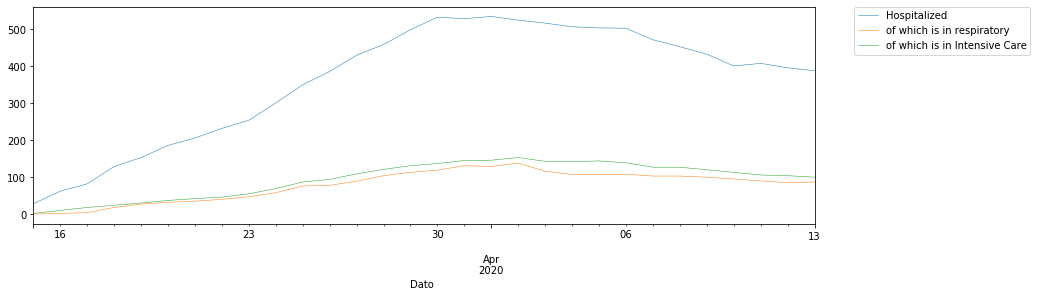

In [871]:
df['Dag']=range(0,len(df))
train_set=df[:30]
test_set=df[30:]
y=train_set['Indlagte i alt']
x=train_set['Heraf på Intensiv']
z=train_set['Heraf i respirator']

plt.figure(figsize=(14,4))
y.plot(linewidth=0.5,label='Hospitalized')
z.plot(linewidth=0.5,label='of which is in respiratory')
x.plot(linewidth=0.5,label='of which is in Intensive Care')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [872]:
train_set

,Indlagte i alt,Heraf på Intensiv,Heraf i respirator,Dag
Dato,,,,
2020-03-15,28,2,0,0
2020-03-16,62,10,2,1
2020-03-17,82,18,4,2
2020-03-18,129,24,18,3
2020-03-19,153,30,27,4
2020-03-20,186,37,32,5
2020-03-21,206,42,35,6
2020-03-22,232,46,40,7
2020-03-23,254,55,47,8


In [873]:
test_set

,Indlagte i alt,Heraf på Intensiv,Heraf i respirator,Dag
Dato,,,,
2020-04-14,380,93,80,30
2020-04-15,362,89,75,31
2020-04-16,353,92,72,32
2020-04-17,350,93,74,33
2020-04-18,317,87,76,34


## Model Specification

The model below is inspired from the pymc3 example of predicting CO2 levels (see above). The model have two priors: A [halfnormal](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.HalfNormal) distribution for the vertical scale parameter and a improper flat prior ([HalfFlat](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.HalfFlat)) over the positive reals for the horizontal scale.  The covariance structure I have used is [the Exponentiated Quadratic kernel](https://docs.pymc.io/api/gp/cov.html#pymc3.gp.cov.ExpQuad) see below for more information.
 

In [944]:
t=train_set['Dag'].values[:,None]
with pm.Model() as model_new:
    x=t
    η = pm.HalfNormal("η", sigma=22)
    ℓ = pm.Gamma("ℓ", alpha=10, beta=0.16)
    #ℓ = pm.HalfFlat("ℓ")
    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ)

    gp = pm.gp.Marginal(cov_func=cov)

    # white noise variance
    σ = pm.HalfNormal("σ", sigma=8, testval=1)
    y_ = gp.marginal_likelihood("y",X=x , y=np.array(y), noise=σ)


The above model can be visualized as a plate graph:

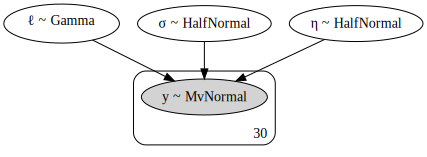

In [945]:
pm.model_to_graphviz(model_new)

The covariance structured I have used is the Exponentiated Quadratic model. This structure is dependent on two parameters lenghtscale (ℓ) and η. The parameter lengthscale (ℓ) controls the horizontal length scale over which the function varies and η controls the vertical varation. Below you can try out different parameter values and see the effect. 

Lengthscale (ℓ) describes how smooth a function is. Small lengthscale value means that function values can change quickly, large values characterize functions that change only slowly. *Lengthscale also determines how far we can reliably extrapolate from the training data*.

The vertical scale (signal variance) η determines variation of function values from their mean. Small values of $\sigma^2$ characterize functions that stay close to their mean value, larger values allow more variation. If the signal variance is too large, the modelled function will be free to chase outliers.

Noise variance $\sigma^2$  is formally not a part of the covariance function itself. It is used by the Gaussian process model to allow for noise present in training data. This parameter specifies how much noise is expected to be present in the data.

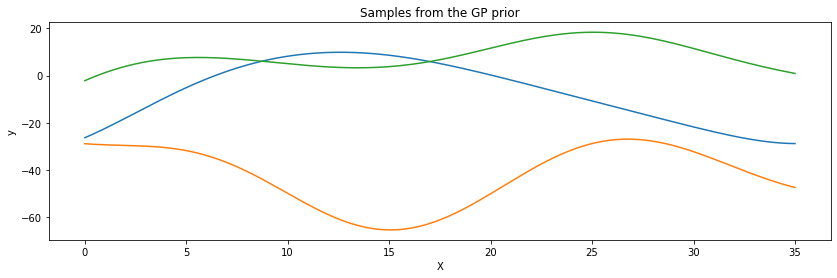

In [970]:
lengthscale =8
eta = 25.0
cov = eta**2 * pm.gp.cov.ExpQuad(1, lengthscale)

X = np.linspace(0, 35, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

I can now sample the model with MCMC (Markov Chain Monte Carlo). I have selected two chains and draw 3000 observations and with 500 draws to warm up the simulation. 

In [947]:
with model_new:
    tr = pm.sample(3000, tune=500, chains=2, cores=1, target_accept=0.95,random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, ℓ, η]
Sampling chain 1, 0 divergences: 100%|██████████| 3500/3500 [00:21<00:00, 163.23it/s]


Here is the density plots for the parameters:

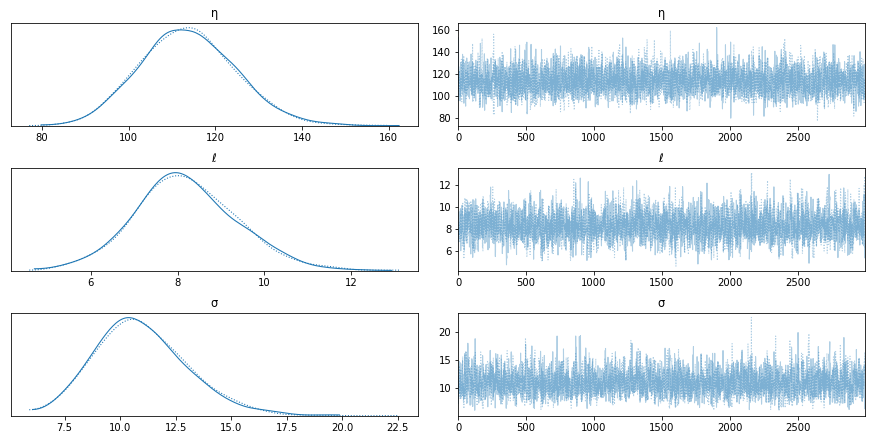

In [948]:
pm.traceplot(tr, var_names=["η", "ℓ", "σ"]);

The traceplot shows the distribution for each variable for two chains that I have sampled from. Both chains look simliar.

## Fit Model

In [949]:
pm.summary(tr).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
η,113.71,10.94,93.48,133.77,0.17,0.12,4349.0,4349.0,4353.0,3543.0,1.0
ℓ,8.21,1.18,5.92,10.41,0.02,0.02,3126.0,3126.0,3121.0,3030.0,1.0
σ,10.98,2.07,7.16,14.84,0.04,0.03,3227.0,3179.0,3265.0,3386.0,1.0


From the above table we can see that the verticale scale is 113 patients and that length scale is 8 days. 


The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. 

In [950]:
mp = pm.find_MAP(model=model_new)

mp

logp = -176.8, ||grad|| = 19.061: 100%|██████████| 18/18 [00:00<00:00, 821.88it/s]  


{'η_log__': array(4.72213918),
 'ℓ_log__': array(2.07189061),
 'σ_log__': array(2.31429055),
 'η': array(112.40845734),
 'ℓ': array(7.93982005),
 'σ': array(10.11774236)}

And here is the highest Posterior Density plots

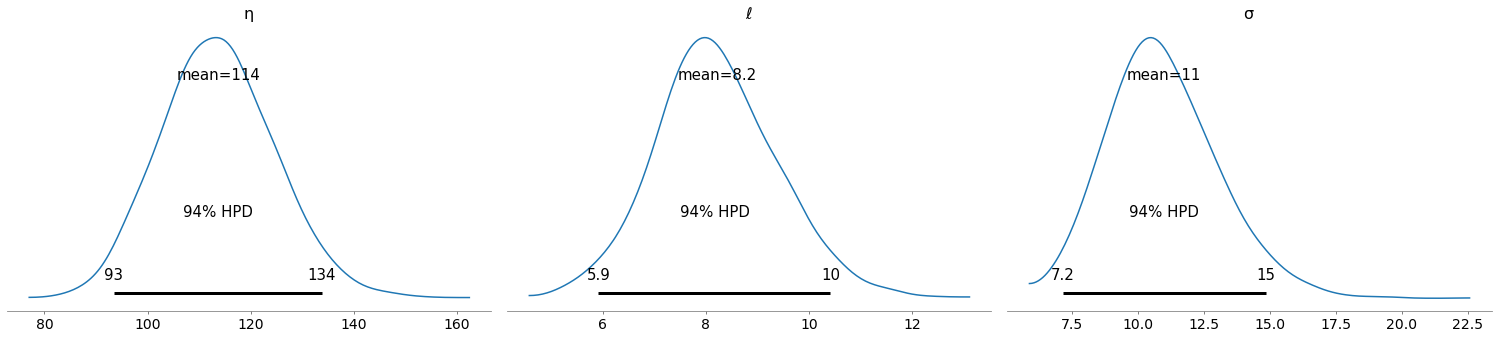

In [951]:
pm.plot_posterior(tr);

The effective sample size. This measure is a estimate of the number of independent samples we got. 

In [952]:
pm.ess(tr).round(2)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    η        float64 4.353e+03
    ℓ        float64 3.121e+03
    σ        float64 3.265e+03

These sample sizes looks ok...

##  Chain Diagnostics

The Gelman-Rubin statistics is a measure of the convergence of the Markov Chains to the target distribution. It should approach 1. 

In [953]:
pm.rhat(tr)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    η        float64 1.0
    ℓ        float64 1.001
    σ        float64 1.001

Gelman–Rubin statistic, a.k.a. the potential scale reduction factor are all very close to one!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x156ac6978>,
      dtype=object)

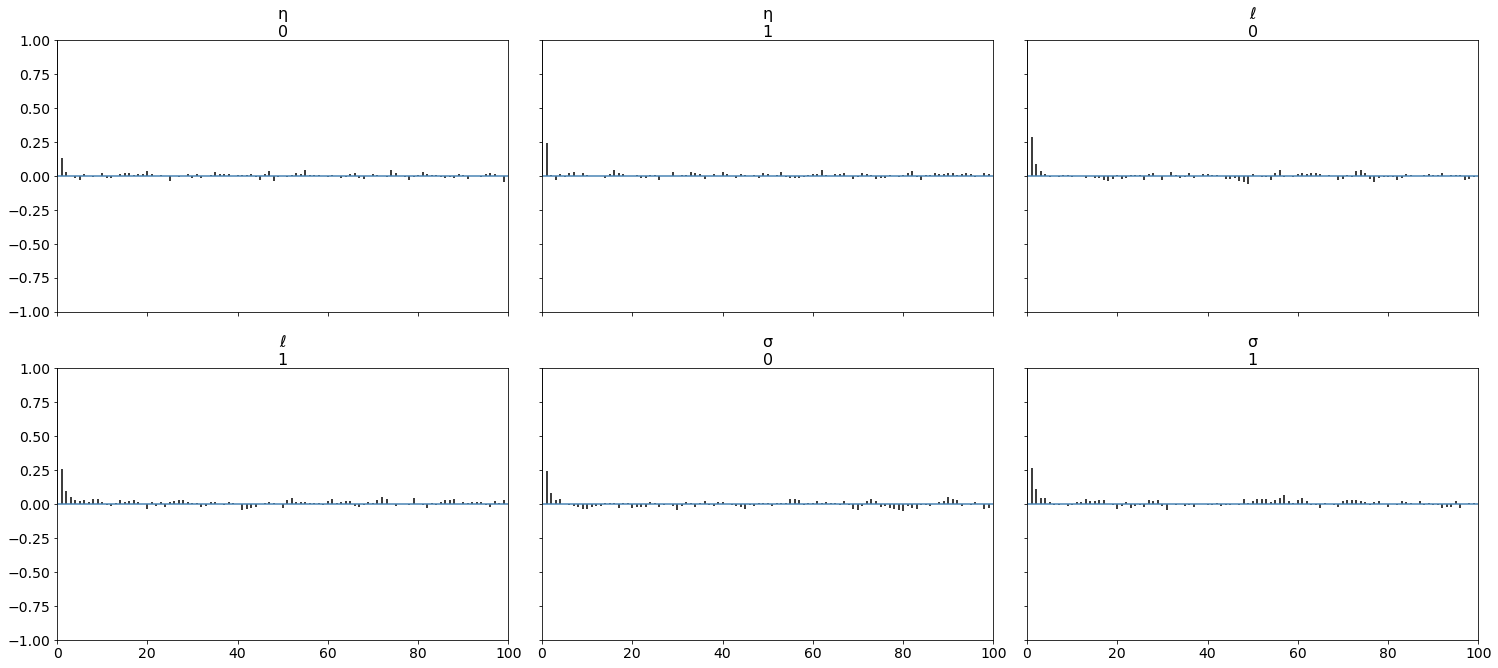

In [954]:
pm.plots.autocorrplot(tr,var_names=["η", "ℓ", "σ"])

The above plots shows autocorrelation from each variable for each sampled chain. They also look fine - no long lag autocorrelations. 

## Predictions on hold-out-data

The model was trained on data from the $15^{th}$ of March to the $13^{th}$ of April. The hold out data was from the $14^{th}$ of April to the $16^{st}$ of April. Below I have calculated the mean absolute error both for in-sample data (training) and the hold-out-data (test). Since $16^{th}$ of April the number of Hospitalzed patients is. These are the most recent figures (as of today $20^{th}$ of April) and the spreadsheet is updated.

First, I can plot the observed Hospitalized against the predictions (in-sample):

In [955]:
with model_new:
    ynew= gp.conditional("ynew", Xnew=t)

with model_new:
    ppc = pm.sample_posterior_predictive(tr, samples=3000, vars=[ynew])

/Users/sorenjohansen/opt/anaconda3/envs/mcmc/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 3000/3000 [00:11<00:00, 250.74it/s]


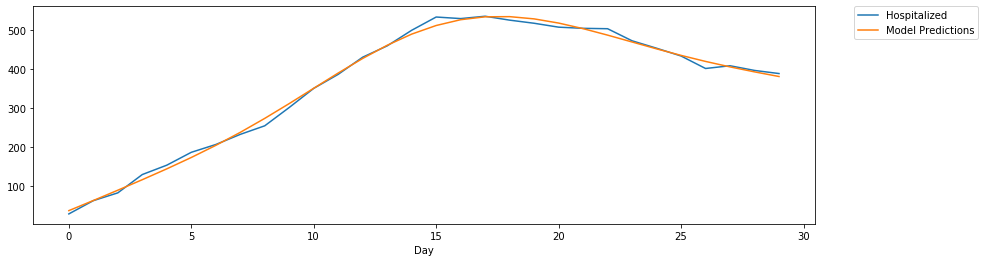

In [956]:
plt.figure(figsize=(14,4))
samples = ppc["ynew"].mean(axis=0)

plot(train_set.Dag,y,label='Hospitalized')
plot(samples,label='Model Predictions')
plt.xlabel("Day"); 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Secondly, I can plot the prediction on the hold-out-data:

In [957]:
tnew = np.linspace(0, 34, 35)[:,None]

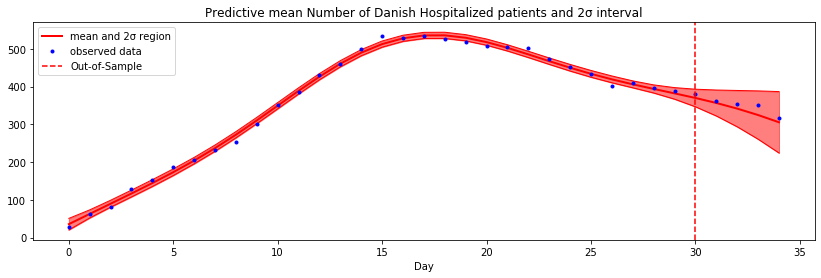

In [958]:
# predict
mu, var = gp.predict(tnew, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(14,4)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(tnew, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(tnew, mu + 2*sd, 'r', lw=1); plt.plot(tnew, mu - 2*sd, 'r', lw=1);
plt.fill_between(tnew.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data
plt.plot(df['Dag'],df['Indlagte i alt'],".b", label="observed data");
ax.axvline(30, ls='--', color='r', label='Out-of-Sample')

plt.xlabel("Day"); 
plt.title("Predictive mean Number of Danish Hospitalized patients and 2σ interval"); plt.legend();


And of cause we can calculate the mean absolute error:

In [959]:
mean_absolute_error(mu, df['Indlagte i alt'])

7.974648749921179

On the out-of sample numbers...

In [960]:
updated_testset=df['Indlagte i alt'][30:]

In [961]:
mean_absolute_error(mu[30:],updated_testset)

12.916655968657825

Here is the mean and standard deviation of (train) hospitalized patients:

In [962]:
train_set['Indlagte i alt'].mean()

362.03333333333336

In [963]:
train_set['Indlagte i alt'].std()

158.5123694364822

And here is the mean and standard deviation of predicted number of cases:

In [964]:
mu.mean()

358.6601289054398

In [965]:
mu.std()

144.22449499269416

## Next step

There is a number of things that can be done:

* Experiment further with different choice of priors and parameters
* Embed the model in a dashboard on Azure
* Try out the model on the number of respiratory patients

We can then calculate the probability that we get more patients for respiratory need then available capacity...

Let me know how your model performs on data from your country.